### The EDA is an attempt to gain any inspiration and hopefully reveal any relationship among odors and between odors and "comfort" (explained below) with the available data.

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from numpy import cumsum, argwhere, meshgrid
from mpl_toolkits import mplot3d
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('odor.csv')
df.head()

,Compound,Character,OSHAPEL
0,Acetaldehyde C2H4O,spice fruit suffocating herb herb,200.0
1,AceticAcid C2H4O2,spice acid,10.0
2,Acetic Anhydride C4H6O3,acid acid,5.0
3,Acetone C3H6O,sweet fruit etherous,1000.0
4,Acetonitrile C2H3N,etherish,40.0


The OSHAPEL of a chemical, in short, is a legal upper limit in the U.S. for exposure of an employee to it. We assume the the agent that we will use in simulations has sensitive sensory system, and thus has a degree of preference proportional to the attribute. 

In [3]:
df.loc[df['Character'].isna(), 'Character'] = '' # remove nan in Odor Character

In [4]:
odors_OSHA = df.loc[:, ['Character', 'OSHAPEL']].copy()
odors_OSHA.dropna(inplace=True) # consider those with OSHA limit

In [5]:
odors_OSHA.reset_index(inplace=True) # reindex the dataframe

In [6]:
# make it a complete disjunctive table
def make_CDT(df):
    index=range(df.shape[0])
    odor_characters = set()
    for i, row in df.iterrows():
        found = re.split(r' +', row['Character']) # preprocessing already removed all beginning and ending spaces
        if len(found) == 0:
            continue
        found = set([a for a in found if a not in odor_characters])
        odor_characters |= found
        df = df.join(pd.DataFrame(0, index=index, columns=found))
        df.loc[i, found] = 1

    df.drop('Character', axis=1, inplace=True) # drop the redundant column Odor Character
    # each column is divided by the percentage of presence of the corresponding label
    for i in range(2, df.shape[1]):
        presence = df.iloc[:, i].sum() / df.shape[0]
        df.iloc[:, i] = df.iloc[:, i] / presence - 1
    return df

In [7]:
odors_OSHA = make_CDT(odors_OSHA)

In [8]:
# Standardization
OSHA = odors_OSHA[['OSHAPEL']].values
standard = preprocessing.StandardScaler()
OSHA_normalized = standard.fit_transform(OSHA)
odors_OSHA.loc[:, 'OSHAPEL'] = OSHA_normalized

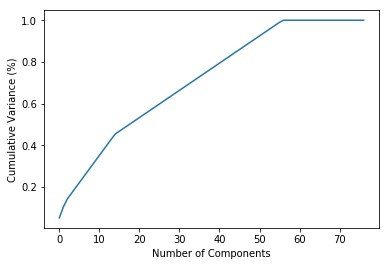

In [9]:
# Multiple Correspondance Analysis
pca = PCA()
pca.fit(odors_OSHA.iloc[:, 2:])
plt.figure()
cumulative_var = cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)') 
plt.show()

In [10]:
n_components = argwhere(cumulative_var >= 0.3)[0, 0]
pca = PCA(n_components)
odors_pca = pca.fit_transform(odors_OSHA.iloc[:, 2:])
n_components

9

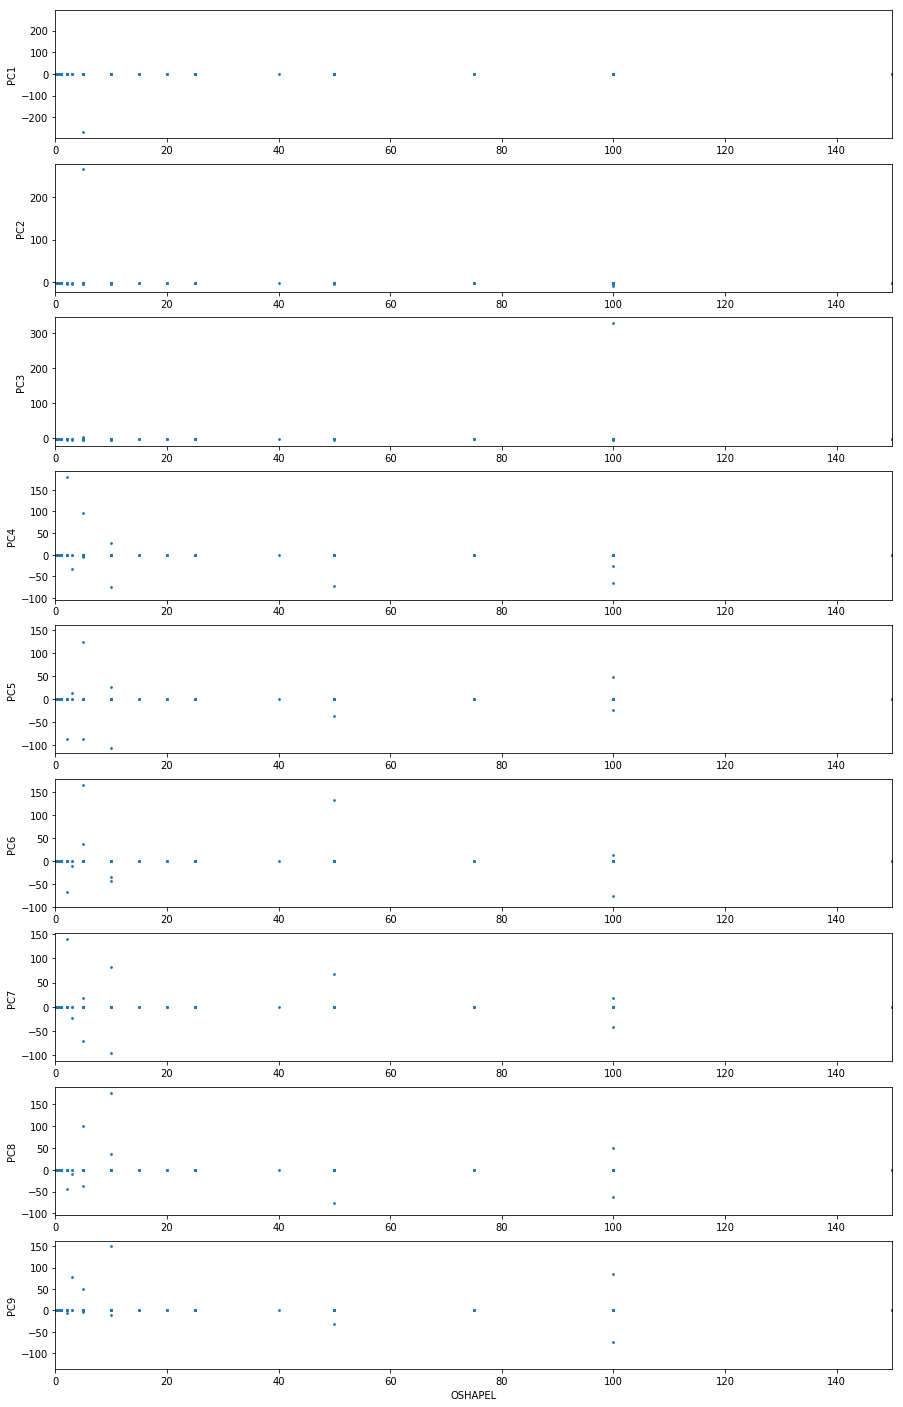

In [11]:
fig, ax = plt.subplots(n_components, 1)
indices_ori = list(odors_OSHA.iloc[:, 0])
for i in range(n_components):
    ax[i].scatter(df.iloc[indices_ori, -1], odors_pca[:, i], s=3)
    ax[i].set_ylabel('PC{}'.format(i+1))
    ax[i].set_xlim(0, 150)
plt.xlabel('OSHAPEL')
fig.set_size_inches((15, 25))
plt.show()

In [12]:
odors_dbscan = DBSCAN().fit_predict(odors_pca)

In [13]:
def within_cluster_relation(k, df, odors_pca, odors_dbscan, odors, n_components):
    plt.figure(figsize=(15, 5))
    indices = argwhere(odors_dbscan == k).T[0]
    indices_ori = list(odors.iloc[indices, 0])
    for i in range(n_components):
        plt.scatter(df.iloc[indices_ori, -1], odors_pca[indices, i], s=5, label='PC{}'.format(i+1))
    plt.xlabel('OSHAPEL')
    plt.ylabel('PC')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [14]:
odors_dbscan

array([-1,  0,  1, -1,  0,  1, -1,  0,  1,  0,  1, -1,  1,  0,  1,  0,  1,
        0,  0,  0, -1,  1,  1,  1, -1,  1,  1,  0,  1,  1,  0,  1, -1, -1,
        0,  0,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  0,  1,  1,
        0,  1,  1,  0,  0,  1,  1,  1,  0,  1,  0,  1,  0, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  1, -1,  0,  1,  1,  1,  1,
        1,  0, -1,  1,  0,  1,  1, -1,  1, -1,  1,  1,  0,  1,  1,  0,  1,
        1,  1, -1,  1,  1,  0,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  0,  1,  1,  0,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  0,  1,  1,  0,  1,  1,
        1,  1,  1,  0,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

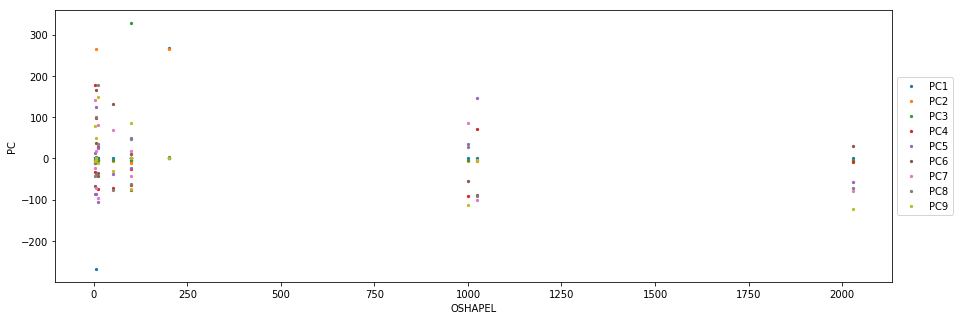

In [15]:
within_cluster_relation(-1, df, odors_pca, odors_dbscan, odors_OSHA, n_components)

Most components are uniformly distributed in their projections onto OSHAPEL.

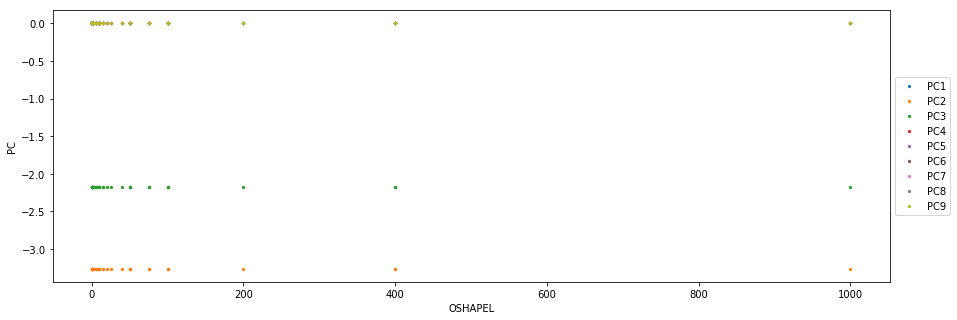

In [16]:
within_cluster_relation(0, df, odors_pca, odors_dbscan, odors_OSHA, n_components)

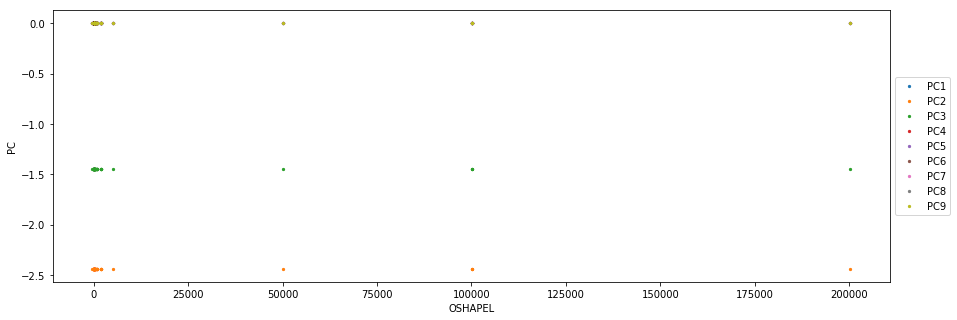

In [17]:
within_cluster_relation(1, df, odors_pca, odors_dbscan, odors_OSHA, n_components)

Does it means PC2, PC3, and PC9 have some relationships?

Text(0, 0.5, 'PC2')

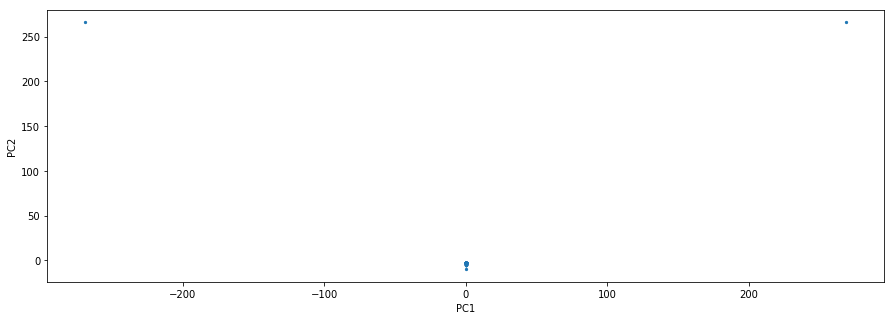

In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(odors_pca[:, 0], odors_pca[:, 1], s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')

(-1, 1)

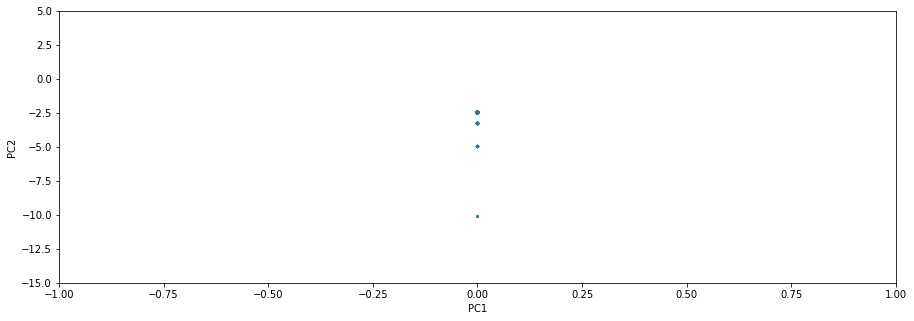

In [19]:
plt.figure(figsize=(15, 5))
plt.scatter(odors_pca[:, 0], odors_pca[:, 1], s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.ylim(-15, 5)
plt.xlim(-1, 1)

In [20]:
odors = df.loc[:, ['Character']].copy()
odors = make_CDT(odors)

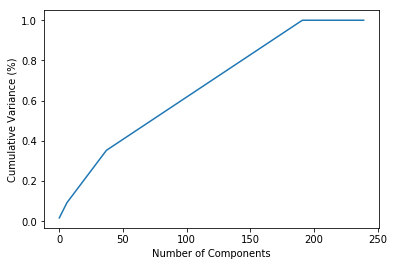

In [21]:
# Multiple Correspondance Analysis
pca = PCA()
pca.fit(odors)
plt.figure()
cumulative_var = cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)') 
plt.show()

In [22]:
n_components = argwhere(cumulative_var >= 0.3)[0, 0]
pca = PCA(n_components)
odors_pca = pca.fit_transform(odors)
n_components

31

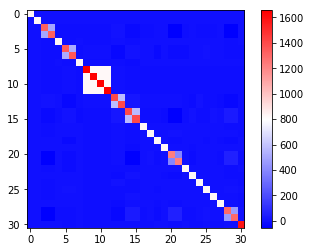

In [23]:
cov = pca.get_covariance()
plt.imshow(cov[:31, :31], cmap='bwr')
plt.colorbar()

In [24]:
odors_dbscan = DBSCAN().fit_predict(odors_pca)

Text(0, 0.5, 'PC2')

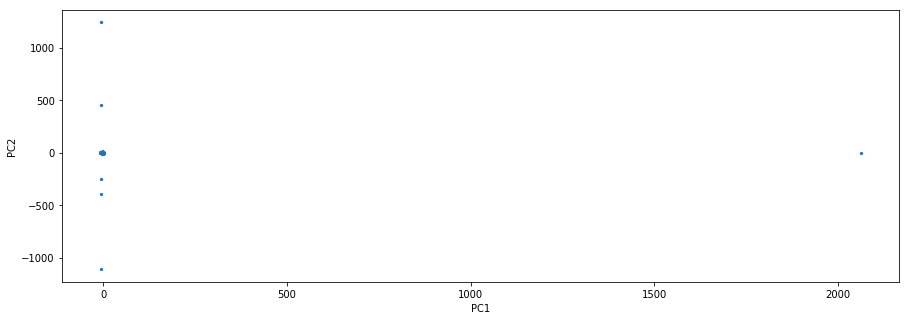

In [25]:
plt.figure(figsize=(15, 5))
plt.scatter(odors_pca[:, 0], odors_pca[:, 1], s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')

(-6, 2)

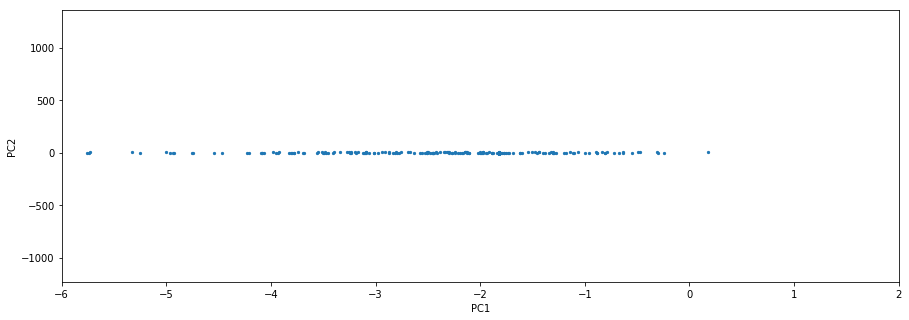

In [26]:
plt.figure(figsize=(15, 5))
plt.scatter(odors_pca[:, 0], odors_pca[:, 1], s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-6, 2)

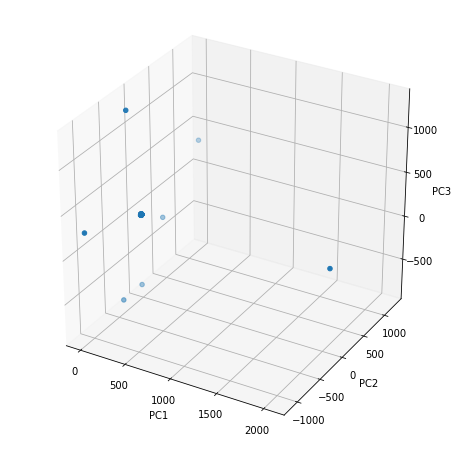

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(odors_pca[:, 0], odors_pca[:, 1], odors_pca[:, 2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

##### In general, the EDA fails to reveal the relationship among odors, possibly because of not choosing the most suitable method and not gathering enough desired data; as well as not experienced enough in EDA. I hypothesize that an analysis that takes chemical functional groups into account can be effective, but that is currently out of my capability. This experience however helps me deciding the proper setup of stimuli.